### Next spike timing
The point of this notebook is to briefly access whether there is a correlation between the standard deviation of spike firing and the distance to the compared to cell.

The standard deviation will be calculated by looking at each transient in cell X and checking when the next transient fires in cell Y and noting the time.

In [66]:
import numpy as np
import xarray as xr
import pandas as pd
from core.backend import open_minian
from scipy.ndimage.measurements import center_of_mass
import dask.array as darr
from matplotlib import pyplot as plt

C:\Users\Michal Lange\AppData\Local\Temp\ipykernel_438812\2985590817.py:5: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.measurements import center_of_mass


In [67]:
# load in xarray
data = open_minian(r"C:\Users\Michal Lange\Documents\Cell_Clustering_Tool\data\05.2023_Tenth_group-AA058_D1-2023_05_05-11_02_42-Miniscope_2-S1\minian")
E = data['E']
verified = E.verified.values.astype(int)
E = E[verified==1]
A = data['A']

In [68]:
# Iterate over all cells and get the starting time for each event
cells_to_event_start = {}
units_ids = E.unit_id.values

for cell in units_ids:
    cell_data = E.sel(unit_id=cell).values

    indices = cell_data.nonzero()
    split_indices = np.split(indices[0], np.where(np.diff(indices[0]) != 1)[0]+1)
    split_indices = [indices_group[0] for indices_group in split_indices]
    cells_to_event_start[cell] = split_indices

In [69]:
cells_to_event_start

{2: [479,
  652,
  1160,
  2297,
  2703,
  4578,
  5196,
  5442,
  6191,
  6578,
  6725,
  7478,
  7601,
  9078,
  9495,
  9767,
  10083,
  13168,
  14330,
  14545,
  15982,
  17149,
  20865,
  21258,
  21369,
  23445,
  24550],
 7: [171, 3623, 7702, 9913, 13886, 18562, 19361, 20408, 24170, 25499, 26387],
 18: [20,
  288,
  561,
  749,
  893,
  1113,
  1789,
  1919,
  2195,
  2426,
  2616,
  3264,
  3355,
  3499,
  4341,
  4406,
  4910,
  5804,
  5871,
  7043,
  7288,
  7877,
  8072,
  8320,
  8404,
  9140,
  9431,
  10134,
  11838,
  12184,
  12368,
  13039,
  14057,
  14163,
  14605,
  14835,
  14910,
  14945,
  15170,
  20798,
  23338,
  23862,
  26974],
 21: [120,
  4021,
  4076,
  5812,
  9792,
  10188,
  10278,
  11466,
  11501,
  13051,
  13266,
  13318,
  13371,
  13459,
  13521,
  13817,
  14191,
  14912,
  16606,
  16658,
  16709,
  17590,
  17727,
  17926,
  25623,
  25675,
  26124,
  26225],
 34: [119,
  543,
  584,
  1499,
  2585,
  3709,
  5534,
  5621,
  6965,
  9014,
  

In [70]:
def compare_cells(cell1, cell2):
    cell1_events = cells_to_event_start[cell1]
    cell2_events = cells_to_event_start[cell2].copy()

    distances = []
    for start1 in cell1_events:
        indices_to_remove = []
        for i, start2 in enumerate(cell2_events):
            if start1 <= start2:
                distances.append(start2 - start1)
                break
            else:
                indices_to_remove.append(i)
        if indices_to_remove:
            # remove all indices in indices_to_remove
            indices_to_remove.reverse()
            for index in indices_to_remove:
                cell2_events.pop(index)
    
    return distances

def centroid(A: xr.DataArray, verbose=False) -> pd.DataFrame:
    def rel_cent(im):
        im_nan = np.isnan(im)
        if im_nan.all():
            return np.array([np.nan, np.nan])
        if im_nan.any():
            im = np.nan_to_num(im)
        cent = np.array(center_of_mass(im))
        return cent / im.shape

    gu_rel_cent = darr.gufunc(
        rel_cent,
        signature="(h,w)->(d)",
        output_dtypes=float,
        output_sizes=dict(d=2),
        vectorize=True,
    )
    cents = xr.apply_ufunc(
        gu_rel_cent,
        A.chunk(dict(height=-1, width=-1)),
        input_core_dims=[["height", "width"]],
        output_core_dims=[["dim"]],
        dask="allowed",
    ).assign_coords(dim=["height", "width"])
    if verbose:
        print("computing centroids")
        with ProgressBar():
            cents = cents.compute()
    cents_df = (
        cents.rename("cents")
        .to_series()
        .dropna()
        .unstack("dim")
        .rename_axis(None, axis="columns")
        .reset_index()
    )
    h_rg = (A.coords["height"].min().values, A.coords["height"].max().values)
    w_rg = (A.coords["width"].min().values, A.coords["width"].max().values)
    cents_df["height"] = cents_df["height"] * (h_rg[1] - h_rg[0]) + h_rg[0]
    cents_df["width"] = cents_df["width"] * (w_rg[1] - w_rg[0]) + w_rg[0]
    return cents_df

centroids = centroid(A)

def calculate_distance(cell1, cell2):
    cell1_row = centroids[centroids['unit_id'] == cell1]
    cell1_center = (cell1_row['height'].values[0], cell1_row['width'].values[0])
    cell2_row = centroids[centroids['unit_id'] == cell2]
    cell2_center = (cell2_row['height'].values[0], cell2_row['width'].values[0])

    return np.sqrt((cell1_center[0] - cell2_center[0])**2 + (cell1_center[1] - cell2_center[1])**2)

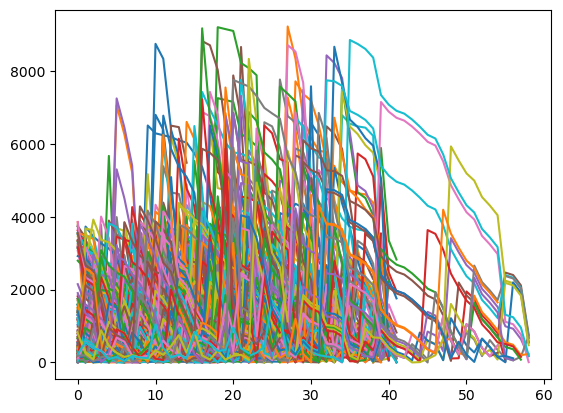

In [71]:
time_results = []
distances = []

for cell in units_ids:
    for other_cell in units_ids:
        if cell == other_cell:
            continue
        times = compare_cells(cell, other_cell)
        if times:
            time_results.append((cell, other_cell, times))

        distance = calculate_distance(cell, other_cell)
        distances.append((cell, other_cell, distance))
    
# plot all the distances
for result in time_results:
    plt.plot(np.arange(len(result[2])), result[2])

plt.show()

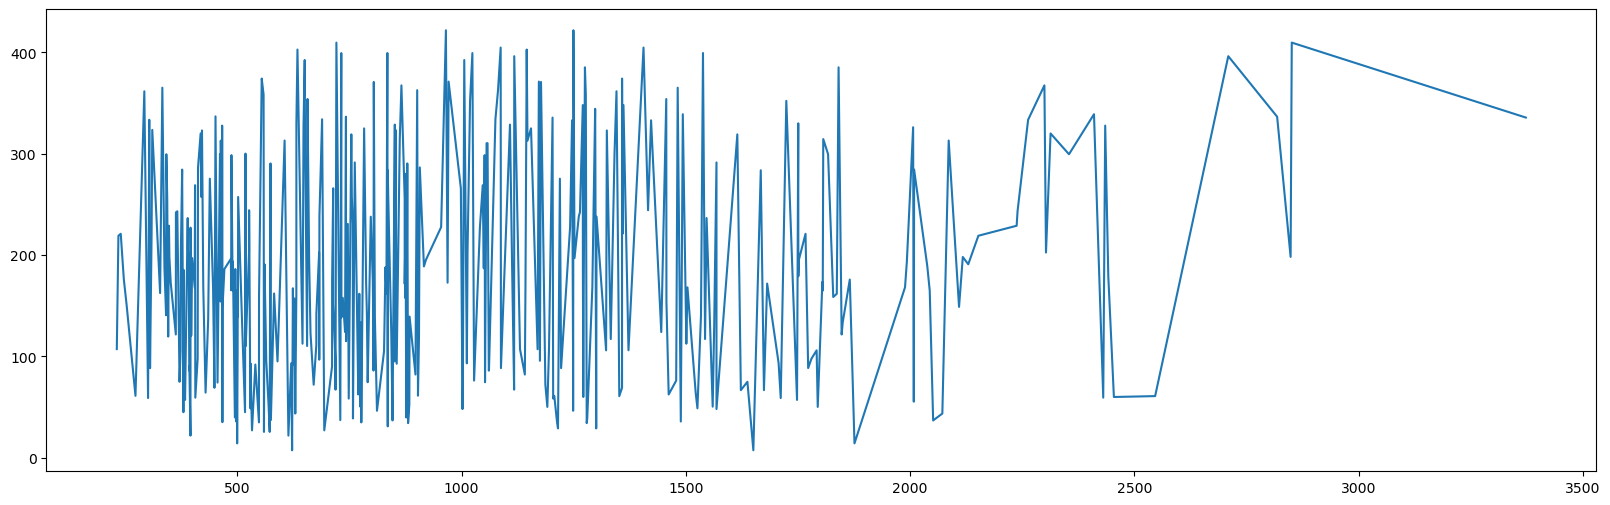

In [72]:
# Put the results into a dataframe
df = pd.DataFrame(time_results, columns=['cell1', 'cell2', 'times'])
# Insert the distance but match cell1 and cell2
df['distance'] = [distance[2] for distance in distances]
# Create a new column for the stds
df['std'] = [np.std(times) for times in df['times']]
# Sort by the stds
df = df.sort_values(by='std')
# Plot the stds to distances
plt.figure(figsize=(20,6))
plt.plot(df['std'], df['distance'])

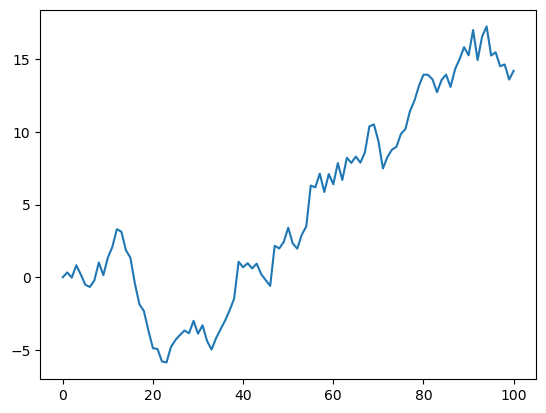

In [73]:
# Random Walk visualization
initial = 0
values = [initial]
for walk in range(10):
    val = np.random.normal(0, 1)
    values.append(values[-1] + val)

# Visualize the random walk
plt.plot(values)